# Inlezen en Berekenen van RSSI-ruis
Deze notebook leest RSSI-metingen in van drie verschillende Raspberry Pi’s, berekent de parameters voor het logaritmisch padverliesmodel en bepaalt de ruis (sigma van de residuen). Daarnaast worden de calibratiepunten visueel weergegeven.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import linregress

## 1. Inlezen van data
We laden zowel de *calibration points* als de *session* bestanden in. De calibration points zijn gemiddelden per afstand (minder nauwkeurig), terwijl de session-bestanden meerdere metingen per afstand bevatten (meer nauwkeurig).

In [42]:
files_points = {
    'pi4': 'rssi_calibration_points_pi4.csv',
    'pi5_rood': 'rssi_calibration_points_pi5_rood.csv',
    'pi5_zwart': 'rssi_calibration_points_pi5_zwart.csv'
}

files_sessions = {
    'pi4': 'rssi_session_20251023_pi4.csv',
    'pi5_rood': 'rssi_session_20251023_pi5_rood.csv',
    'pi5_zwart': 'rssi_session_20251023_pi5_zwart.csv'
}

## 2. Functie om parameters te berekenen
We gebruiken een logaritmische regressie van de vorm:
$$ RSSI = C - 10n \log_{10}(d) $$
waarbij:
- *n* het padverliesexponent is,
- *C* de intercept (RSSI bij 1 meter),
- *sigma_residual_db* de standaardafwijking van de residuen (ruis) is.

In [43]:
def bereken_parameters(df):
    x = np.log10(df['dist_m'])
    y = df['rssi_dbm']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    residuals = y - (slope * x + intercept)
    sigma_residual_db = np.std(residuals)
    return {
        'path_loss_n': -slope,
        'C_intercept': intercept,
        'slope_c1': slope,
        'sigma_residual_db': sigma_residual_db,
        'R2': r_value ** 2
    }

## 3. Parameters berekenen per Raspberry Pi
We groeperen de data per afstand en berekenen de gemiddelde RSSI, vervolgens voeren we de regressie uit en slaan we de resultaten op.

In [44]:
results = {}
for naam, file in files_sessions.items():
    df = pd.read_csv(file)
    df.columns = [c.strip().lower() for c in df.columns]
    grouped = df.groupby('dist_m').mean(numeric_only=True).reset_index()
    results[naam] = bereken_parameters(grouped)
results

{'pi4': {'path_loss_n': np.float64(21.718898189350607),
  'C_intercept': np.float64(-43.188934055923895),
  'slope_c1': np.float64(-21.718898189350607),
  'sigma_residual_db': np.float64(3.6113509310850835),
  'R2': np.float64(0.810626841437135)},
 'pi5_rood': {'path_loss_n': np.float64(16.796311139775554),
  'C_intercept': np.float64(-46.74896712940097),
  'slope_c1': np.float64(-16.796311139775554),
  'sigma_residual_db': np.float64(3.2512832124162534),
  'R2': np.float64(0.7595302328304014)},
 'pi5_zwart': {'path_loss_n': np.float64(22.869309118836547),
  'C_intercept': np.float64(-40.738447137210784),
  'slope_c1': np.float64(-22.869309118836547),
  'sigma_residual_db': np.float64(4.004549699679602),
  'R2': np.float64(0.7942303189393113)}}

## 4. Gecombineerde parameters
We nemen het gemiddelde van alle individuele resultaten om een gecombineerd model te bekomen.

In [45]:
params = {'combined': {}}
all_vals = np.array([r['path_loss_n'] for r in results.values()])
params['combined']['path_loss_n'] = float(np.mean(all_vals))
params['combined']['C_intercept'] = float(np.mean([r['C_intercept'] for r in results.values()]))
params['combined']['slope_c1'] = float(np.mean([r['slope_c1'] for r in results.values()]))
params['combined']['sigma_residual_db'] = float(np.mean([r['sigma_residual_db'] for r in results.values()]))
params['combined']['R2'] = float(np.mean([r['R2'] for r in results.values()]))
params

{'combined': {'path_loss_n': 20.461506149320904,
  'C_intercept': -43.55878277417855,
  'slope_c1': -20.461506149320904,
  'sigma_residual_db': 3.6223946143936465,
  'R2': 0.7881291310689492}}

## 5. Exporteren naar JSON
We slaan zowel de individuele als gecombineerde parameters op in een JSON-bestand.

In [46]:
with open('rssi_parameters.json', 'w') as f:
    json.dump({'individual': results, **params}, f, indent=4)
print('Parameters opgeslagen in rssi_parameters.json')

Parameters opgeslagen in rssi_parameters.json


## 6. Visualisatie van calibratiepunten
We tonen voor elke Raspberry Pi een plot van RSSI versus afstand, zodat het verschil in signaalsterkte duidelijk zichtbaar is.

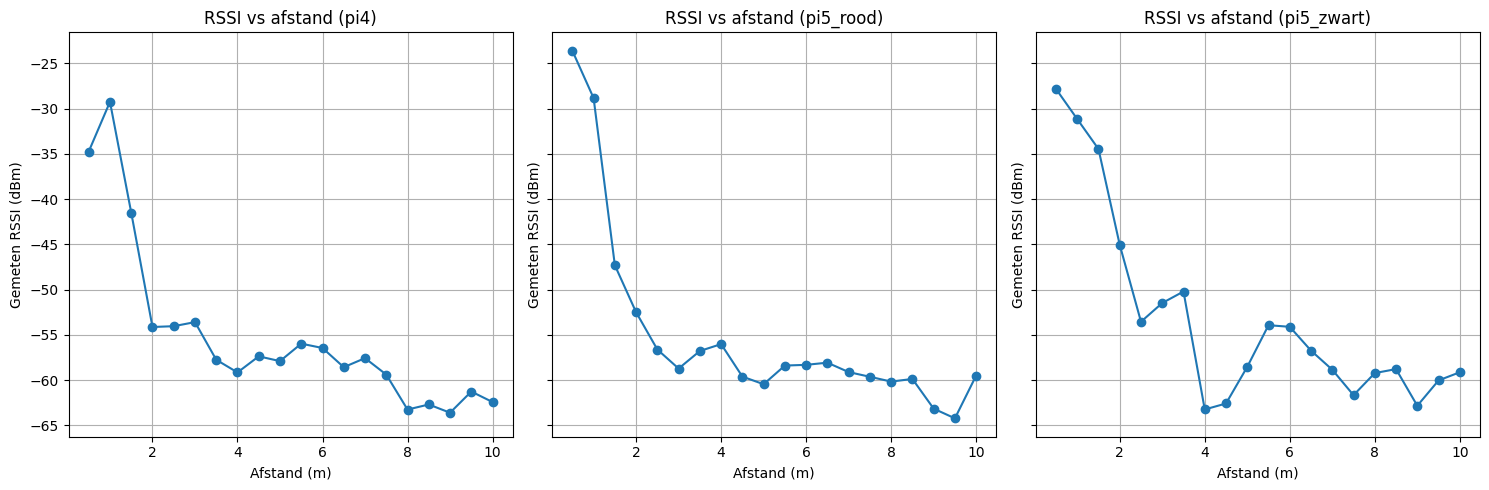

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax, (naam, file) in zip(axes, files_points.items()):
    df = pd.read_csv(file)
    df.columns = [c.strip().lower() for c in df.columns]
    ax.plot(df['dist_m'], df['rssi_dbm'], 'o-', label=f'{naam}')
    ax.set_title(f'RSSI vs afstand ({naam})')
    ax.set_xlabel('Afstand (m)')
    ax.set_ylabel('Gemeten RSSI (dBm)')
    ax.grid(True)
plt.tight_layout()
plt.show()